In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import linregress

nba_df= pd.read_csv("Resources/shot_logs.csv")

In [90]:
nba_df.head()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148


In [91]:
#id unique shooters, and count
nba_shooter= nba_df['player_name'].unique()
shooters= len(nba_shooter)
#print number of unique shooters
print(f"We have {shooters} unique shooters in this dataset.")
#check number of defenders
name_check= nba_df['CLOSEST_DEFENDER_PLAYER_ID'].unique()
defenders=len(name_check)
#print number of unique defenders
print(f"We have {defenders} unique defenders in this dataset.")
#check to see if anyone has the same name, utilizing both name and id
same_name= nba_df['CLOSEST_DEFENDER'].unique()
same_name_check= len(same_name)
print(f"Comparing the number of pairs of defenders with the same name: {defenders-same_name_check}")

#drop columns we won't use
cleaned_df= nba_df.drop(columns=["MATCHUP", "LOCATION", "DRIBBLES", "TOUCH_TIME"])
cleaned_df

We have 281 unique shooters in this dataset.
We have 474 unique defenders in this dataset.
Comparing the number of pairs of defenders with the same name: 1


,GAME_ID,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,W,24,1,1,1:09,10.8,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,W,24,2,1,0:14,3.4,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,W,24,3,1,0:00,NaN,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,W,24,4,2,11:47,10.3,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,W,24,5,2,10:34,10.9,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128064,21400006,L,-16,5,3,1:52,18.3,8.7,2,missed,"Smart, Marcus",203935,0.8,0,0,jarrett jack,101127
128065,21400006,L,-16,6,4,11:28,19.8,0.6,2,made,"Turner, Evan",202323,0.6,1,2,jarrett jack,101127
128066,21400006,L,-16,7,4,11:10,23.0,16.9,2,made,"Thornton, Marcus",201977,4.2,1,2,jarrett jack,101127
128067,21400006,L,-16,8,4,2:37,9.1,18.3,2,missed,"Bradley, Avery",202340,3.0,0,0,jarrett jack,101127


In [92]:
#rename columns to keep capitals case consistent
cleaned_df.rename(columns={"player_name": "PLAYER_NAME",
                  "player_id": "PLAYER_ID"}, inplace=True)

In [93]:
cleaned_df.dtypes

GAME_ID                         int64
W                              object
FINAL_MARGIN                    int64
SHOT_NUMBER                     int64
PERIOD                          int64
GAME_CLOCK                     object
SHOT_CLOCK                    float64
SHOT_DIST                     float64
PTS_TYPE                        int64
SHOT_RESULT                    object
CLOSEST_DEFENDER               object
CLOSEST_DEFENDER_PLAYER_ID      int64
CLOSE_DEF_DIST                float64
FGM                             int64
PTS                             int64
PLAYER_NAME                    object
PLAYER_ID                       int64
dtype: object

In [94]:
#split game clock by the ":" so we can use minutes:seconds for math and comparisons
to_clean= cleaned_df["GAME_CLOCK"].str.split(":",expand=True).astype(int)
#0 is minutes, 1 is seconds
cleaned_df["GAME_CLOCK_SECONDS"]=to_clean[0]*60 + to_clean[1]
#initialize column as empty so we can add to it
cleaned_df["TOTAL_TIME_SECONDS"] = ""
for index,rows in cleaned_df.iterrows(): 
    #multiplier is number of seconds remaining in game. for fourth quarter, multiplier is 0
    multiplier= 0
    #first period in game seconds remaining
    if rows["PERIOD"] == 1:
        multiplier= 36*60
    elif rows["PERIOD"] == 2:
        multiplier= 24*60
    elif rows["PERIOD"] == 3:
        multiplier= 12*60
    #add to new column, multiplier plus seconds at that index    
    cleaned_df.loc[index,["TOTAL_TIME_SECONDS"]]=multiplier+cleaned_df["GAME_CLOCK_SECONDS"][index]

cleaned_df

,GAME_ID,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,PLAYER_NAME,PLAYER_ID,GAME_CLOCK_SECONDS,TOTAL_TIME_SECONDS
0,21400899,W,24,1,1,1:09,10.8,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148,69,2229
1,21400899,W,24,2,1,0:14,3.4,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148,14,2174
2,21400899,W,24,3,1,0:00,NaN,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148,0,2160
3,21400899,W,24,4,2,11:47,10.3,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148,707,2147
4,21400899,W,24,5,2,10:34,10.9,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148,634,2074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128064,21400006,L,-16,5,3,1:52,18.3,8.7,2,missed,"Smart, Marcus",203935,0.8,0,0,jarrett jack,101127,112,832
128065,21400006,L,-16,6,4,11:28,19.8,0.6,2,made,"Turner, Evan",202323,0.6,1,2,jarrett jack,101127,688,688
128066,21400006,L,-16,7,4,11:10,23.0,16.9,2,made,"Thornton, Marcus",201977,4.2,1,2,jarrett jack,101127,670,670
128067,21400006,L,-16,8,4,2:37,9.1,18.3,2,missed,"Bradley, Avery",202340,3.0,0,0,jarrett jack,101127,157,157


In [95]:
#rename split dataframe to minutes and seconds for clarity
to_clean.rename(columns={0: "MINUTES", 1: "SECONDS"}, inplace=True)
#add to original dataframe
cleaned_df=pd.concat([cleaned_df, to_clean], axis=1)

In [96]:
#convert all NaN in Shot_clock category to game_clock
cleaned_df["SHOT_CLOCK"].fillna(cleaned_df["SECONDS"], inplace=True)
#display dataframe to check if shot clock is changed
cleaned_df

,GAME_ID,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,SHOT_DIST,PTS_TYPE,SHOT_RESULT,...,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,PLAYER_NAME,PLAYER_ID,GAME_CLOCK_SECONDS,TOTAL_TIME_SECONDS,MINUTES,SECONDS
0,21400899,W,24,1,1,1:09,10.8,7.7,2,made,...,101187,1.3,1,2,brian roberts,203148,69,2229,1,9
1,21400899,W,24,2,1,0:14,3.4,28.2,3,missed,...,202711,6.1,0,0,brian roberts,203148,14,2174,0,14
2,21400899,W,24,3,1,0:00,0.0,10.1,2,missed,...,202711,0.9,0,0,brian roberts,203148,0,2160,0,0
3,21400899,W,24,4,2,11:47,10.3,17.2,2,missed,...,203900,3.4,0,0,brian roberts,203148,707,2147,11,47
4,21400899,W,24,5,2,10:34,10.9,3.7,2,missed,...,201152,1.1,0,0,brian roberts,203148,634,2074,10,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128064,21400006,L,-16,5,3,1:52,18.3,8.7,2,missed,...,203935,0.8,0,0,jarrett jack,101127,112,832,1,52
128065,21400006,L,-16,6,4,11:28,19.8,0.6,2,made,...,202323,0.6,1,2,jarrett jack,101127,688,688,11,28
128066,21400006,L,-16,7,4,11:10,23.0,16.9,2,made,...,201977,4.2,1,2,jarrett jack,101127,670,670,11,10
128067,21400006,L,-16,8,4,2:37,9.1,18.3,2,missed,...,202340,3.0,0,0,jarrett jack,101127,157,157,2,37


In [97]:
# dropped all rows (1205) that did not have a shot clock value
cleaned_df = cleaned_df[cleaned_df["SHOT_CLOCK"] <= 24]

cleaned_df

,GAME_ID,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,SHOT_DIST,PTS_TYPE,SHOT_RESULT,...,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,PLAYER_NAME,PLAYER_ID,GAME_CLOCK_SECONDS,TOTAL_TIME_SECONDS,MINUTES,SECONDS
0,21400899,W,24,1,1,1:09,10.8,7.7,2,made,...,101187,1.3,1,2,brian roberts,203148,69,2229,1,9
1,21400899,W,24,2,1,0:14,3.4,28.2,3,missed,...,202711,6.1,0,0,brian roberts,203148,14,2174,0,14
2,21400899,W,24,3,1,0:00,0.0,10.1,2,missed,...,202711,0.9,0,0,brian roberts,203148,0,2160,0,0
3,21400899,W,24,4,2,11:47,10.3,17.2,2,missed,...,203900,3.4,0,0,brian roberts,203148,707,2147,11,47
4,21400899,W,24,5,2,10:34,10.9,3.7,2,missed,...,201152,1.1,0,0,brian roberts,203148,634,2074,10,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128064,21400006,L,-16,5,3,1:52,18.3,8.7,2,missed,...,203935,0.8,0,0,jarrett jack,101127,112,832,1,52
128065,21400006,L,-16,6,4,11:28,19.8,0.6,2,made,...,202323,0.6,1,2,jarrett jack,101127,688,688,11,28
128066,21400006,L,-16,7,4,11:10,23.0,16.9,2,made,...,201977,4.2,1,2,jarrett jack,101127,670,670,11,10
128067,21400006,L,-16,8,4,2:37,9.1,18.3,2,missed,...,202340,3.0,0,0,jarrett jack,101127,157,157,2,37


In [98]:
#export to csv
cleaned_df.to_csv("Output_Data/Final_nba_df.csv", index= False)

In [99]:
# find all the different timepoints
shot_clock_timepoints = cleaned_df.groupby(["SHOT_CLOCK"])
shot_clock_remaining = shot_clock_timepoints["SHOT_CLOCK"].unique()
# calculate number of shots at each timepoint
shot_clock_shots = shot_clock_timepoints["SHOT_CLOCK"].count()
# calculate number of shots made at each timepoint
shots_made = shot_clock_timepoints["FGM"].sum()
# calculate FG % at each timepoint
fg_percent = shots_made / shot_clock_shots * 100

# make a new dataframe for graphing
graph_df = pd.DataFrame({
    "FG Attempts": shot_clock_shots,
    "FGs Made": shots_made,
    "FG%": fg_percent
})

# reset the index
graph_df = graph_df.reset_index()
graph_df = graph_df.rename(columns={"SHOT_CLOCK": "Shot Clock"})

graph_df

,Shot Clock,FG Attempts,FGs Made,FG%
0,0.0,584,90,15.410959
1,0.1,67,21,31.343284
2,0.2,64,12,18.750000
3,0.3,71,13,18.309859
4,0.4,88,20,22.727273
...,...,...,...,...
236,23.6,147,74,50.340136
237,23.7,128,60,46.875000
238,23.8,112,46,41.071429
239,23.9,91,32,35.164835


The r-value is: 0.803450533698892


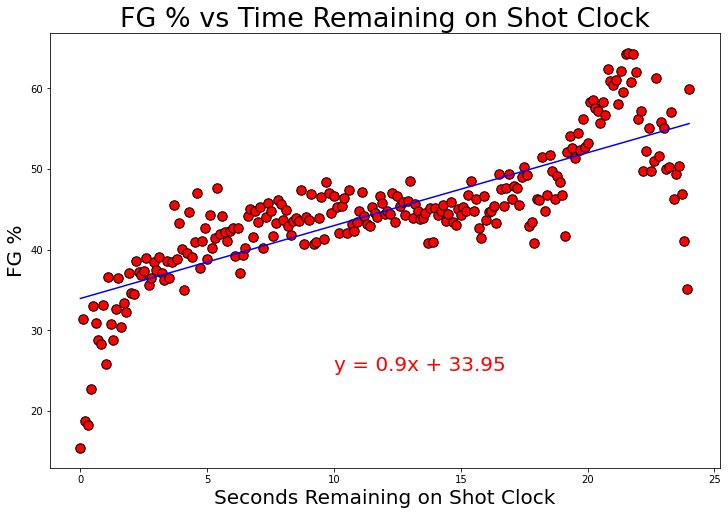

In [100]:
fig1, ax1 = plt.subplots(figsize=(12, 8))

x_value = graph_df["Shot Clock"]
y_value = graph_df["FG%"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_value, y_value)
regress_values = x_value * slope + intercept

line_eq = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2))
plt.scatter(x_value, y_value, s=90, c="r", edgecolor="k")

# plot regression line
plt.plot(x_value, regress_values, "b-")

# print equation in graph
plt.annotate(line_eq, (10,25), fontsize=20, color="r")


# add labels for readability
plt.title("FG % vs Time Remaining on Shot Clock", fontsize=27)
plt.xlabel("Seconds Remaining on Shot Clock", fontsize=20)
plt.ylabel("FG %", fontsize=20)

print(f"The r-value is: {rvalue}")

plt.savefig("output_data/FG%1.png")

plt.show()

In [101]:
two_pointer = cleaned_df.loc[cleaned_df["PTS_TYPE"] <= 2]
three_pointer = cleaned_df.loc[cleaned_df["PTS_TYPE"] > 2]

In [102]:
two_pointer

,GAME_ID,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,SHOT_DIST,PTS_TYPE,SHOT_RESULT,...,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,PLAYER_NAME,PLAYER_ID,GAME_CLOCK_SECONDS,TOTAL_TIME_SECONDS,MINUTES,SECONDS
0,21400899,W,24,1,1,1:09,10.8,7.7,2,made,...,101187,1.3,1,2,brian roberts,203148,69,2229,1,9
2,21400899,W,24,3,1,0:00,0.0,10.1,2,missed,...,202711,0.9,0,0,brian roberts,203148,0,2160,0,0
3,21400899,W,24,4,2,11:47,10.3,17.2,2,missed,...,203900,3.4,0,0,brian roberts,203148,707,2147,11,47
4,21400899,W,24,5,2,10:34,10.9,3.7,2,missed,...,201152,1.1,0,0,brian roberts,203148,634,2074,10,34
5,21400899,W,24,6,2,8:15,9.1,18.4,2,missed,...,101114,2.6,0,0,brian roberts,203148,495,1935,8,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128064,21400006,L,-16,5,3,1:52,18.3,8.7,2,missed,...,203935,0.8,0,0,jarrett jack,101127,112,832,1,52
128065,21400006,L,-16,6,4,11:28,19.8,0.6,2,made,...,202323,0.6,1,2,jarrett jack,101127,688,688,11,28
128066,21400006,L,-16,7,4,11:10,23.0,16.9,2,made,...,201977,4.2,1,2,jarrett jack,101127,670,670,11,10
128067,21400006,L,-16,8,4,2:37,9.1,18.3,2,missed,...,202340,3.0,0,0,jarrett jack,101127,157,157,2,37


In [103]:
three_pointer

,GAME_ID,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,SHOT_DIST,PTS_TYPE,SHOT_RESULT,...,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,PLAYER_NAME,PLAYER_ID,GAME_CLOCK_SECONDS,TOTAL_TIME_SECONDS,MINUTES,SECONDS
1,21400899,W,24,2,1,0:14,3.4,28.2,3,missed,...,202711,6.1,0,0,brian roberts,203148,14,2174,0,14
8,21400899,W,24,9,4,5:14,12.4,24.6,3,missed,...,202721,7.3,0,0,brian roberts,203148,314,314,5,14
9,21400890,W,1,1,2,11:32,17.4,22.4,3,missed,...,201961,19.8,0,0,brian roberts,203148,692,2132,11,32
10,21400890,W,1,2,2,6:30,16.0,24.5,3,missed,...,202391,4.7,0,0,brian roberts,203148,390,1830,6,30
13,21400882,W,15,1,4,9:10,4.4,26.4,3,missed,...,2584,4.4,0,0,brian roberts,203148,550,550,9,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128009,21400138,L,-10,4,3,0:40,16.0,25.9,3,missed,...,203468,1.8,0,0,jarrett jack,101127,40,760,0,40
128016,21400138,L,-10,11,4,0:34,21.1,23.0,3,missed,...,203459,1.7,0,0,jarrett jack,101127,34,34,0,34
128031,21400116,L,-8,4,4,4:19,14.0,23.8,3,missed,...,202738,2.8,0,0,jarrett jack,101127,259,259,4,19
128057,21400033,W,12,2,2,10:02,7.3,22.1,3,missed,...,201571,2.9,0,0,jarrett jack,101127,602,2042,10,2


In [104]:
# find all the different timepoints
shot_clock_timepoints2 = two_pointer.groupby(["SHOT_CLOCK"])
shot_clock_remaining2 = shot_clock_timepoints2["SHOT_CLOCK"].unique()
# calculate number of shots at each timepoint
shot_clock_shots2 = shot_clock_timepoints2["SHOT_CLOCK"].count()
# calculate number of shots made at each timepoint
shots_made2 = shot_clock_timepoints2["FGM"].sum()
# calculate FG % at each timepoint
fg_percent2 = shots_made2 / shot_clock_shots2 * 100

# make a new dataframe for graphing
graph_df2 = pd.DataFrame({
    "FG Attempts": shot_clock_shots2,
    "FGs Made": shots_made2,
    "FG%": fg_percent2
})

# reset the index
graph_df2 = graph_df2.reset_index()
graph_df2 = graph_df2.rename(columns={"SHOT_CLOCK": "Shot Clock"})

graph_df2

,Shot Clock,FG Attempts,FGs Made,FG%
0,0.0,220,55,25.000000
1,0.1,48,16,33.333333
2,0.2,40,8,20.000000
3,0.3,48,8,16.666667
4,0.4,49,14,28.571429
...,...,...,...,...
236,23.6,138,72,52.173913
237,23.7,125,59,47.200000
238,23.8,108,43,39.814815
239,23.9,91,32,35.164835


The r-value is: 0.8015611842454609


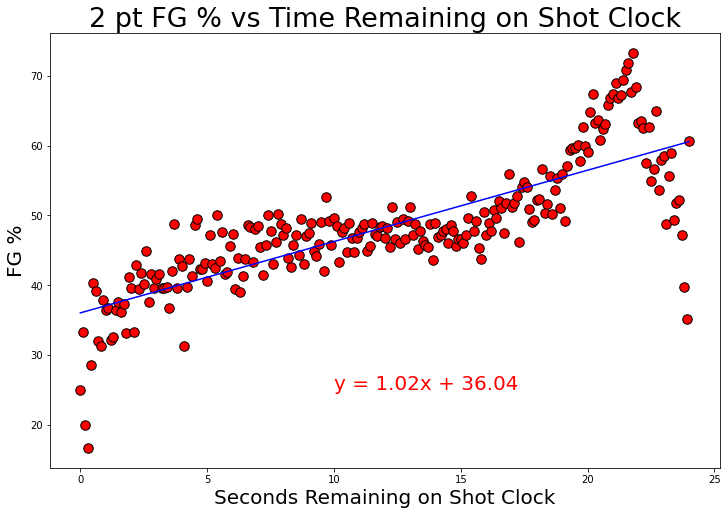

In [105]:
fig1, ax1 = plt.subplots(figsize=(12, 8))
x_value = graph_df2["Shot Clock"]
y_value = graph_df2["FG%"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_value, y_value)
regress_values = x_value * slope + intercept

line_eq = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2))
plt.scatter(x_value, y_value, s=90, c="r", edgecolor="k")

# plot regression line
plt.plot(x_value, regress_values, "b-")

# print equation in graph
plt.annotate(line_eq, (10,25), fontsize=20, color="r")

# add labels for readibility
plt.title("2 pt FG % vs Time Remaining on Shot Clock", fontsize=27)
plt.xlabel("Seconds Remaining on Shot Clock", fontsize=20)
plt.ylabel("FG %", fontsize=20)

print(f"The r-value is: {rvalue}")

plt.savefig("output_data/FG%2.png")

plt.show()

In [106]:
# find all the different timepoints
shot_clock_timepoints3 = three_pointer.groupby(["SHOT_CLOCK"])
shot_clock_remaining3 = shot_clock_timepoints3["SHOT_CLOCK"].unique()
# calculate number of shots at each timepoint
shot_clock_shots3 = shot_clock_timepoints3["SHOT_CLOCK"].count()
# calculate number of shots made at each timepoint
shots_made3 = shot_clock_timepoints3["FGM"].sum()
# calculate FG % at each timepoint
fg_percent3 = shots_made3 / shot_clock_shots3 * 100

# make a new dataframe for graphing
graph_df3 = pd.DataFrame({
    "FG Attempts": shot_clock_shots3,
    "FGs Made": shots_made3,
    "FG%": fg_percent3
})

# reset the index
graph_df3 = graph_df3.reset_index()
graph_df3 = graph_df3.rename(columns={"SHOT_CLOCK": "Shot Clock"})

graph_df3

,Shot Clock,FG Attempts,FGs Made,FG%
0,0.0,364,35,9.615385
1,0.1,19,5,26.315789
2,0.2,24,4,16.666667
3,0.3,23,5,21.739130
4,0.4,39,6,15.384615
...,...,...,...,...
235,23.5,11,2,18.181818
236,23.6,9,2,22.222222
237,23.7,3,1,33.333333
238,23.8,4,3,75.000000


The r-value is: 0.36473832307707527


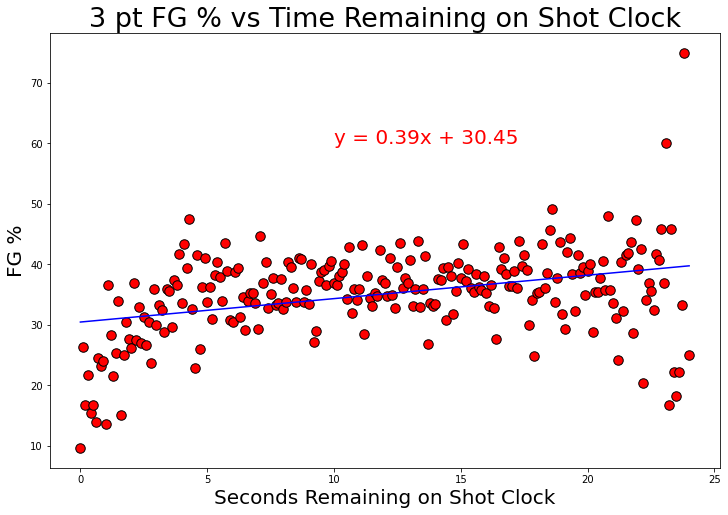

In [107]:
fig1, ax1 = plt.subplots(figsize=(12, 8))
x_value = graph_df3["Shot Clock"]
y_value = graph_df3["FG%"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_value, y_value)
regress_values = x_value * slope + intercept

line_eq = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2))
plt.scatter(x_value, y_value, s=90, c="r", edgecolor="k")

# plot regression line
plt.plot(x_value, regress_values, "b-")

# print equation in graph
plt.annotate(line_eq, (10,60), fontsize=20, color="r")

# add labels for readibility
plt.title("3 pt FG % vs Time Remaining on Shot Clock", fontsize=27)
plt.xlabel("Seconds Remaining on Shot Clock", fontsize=20)
plt.ylabel("FG %", fontsize=20)

print(f"The r-value is: {rvalue}")

plt.savefig("output_data/FG%3.png")

plt.show()

In [108]:
# create bins and bin labels
bin_size = [0, 5, 10, 15, 20, 25]
bin_label_size = ["0-5.0", "5.1-11.0", "11.1-15.0", "15.1-20.0", "20.1-24"]

# create index
graph_df["Shot Clock"] = pd.cut(graph_df["Shot Clock"], bin_size, labels=bin_label_size)

# group dataframe by bins
shot_clock_binning = graph_df.groupby(["Shot Clock"])

# create value(s) for dataframe
fg_attempted = shot_clock_binning["FG Attempts"].sum()
fg_made = shot_clock_binning["FGs Made"].sum()
fg_per = fg_made / fg_attempted * 100

# create dataframe
bin_df = pd.DataFrame({
    "FG Attempts": fg_attempted,
    "FGs Made": fg_made,
    "FG%": fg_per
    })

# format cell for cleaner look
bin_df["FG%"] = bin_df["FG%"].map("{:.2f}".format)

bin_df

,FG Attempts,FGs Made,FG%
Shot Clock,,,
0-5.0,16140,5904,36.58
5.1-11.0,30698,13380,43.59
11.1-15.0,38555,17234,44.70
15.1-20.0,27391,12958,47.31
20.1-24,13496,7799,57.79
